## Sequential AIS Data Processing Notebook
This notebook performs data insertion, noise filtering, and delta_t calculation for AIS data.

## Setup: Imports and Configuration

In [ ]:
import pandas as pd
from tqdm import tqdm
from pymongo import MongoClient, ASCENDING
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np # For NaN checks and histogram binning

def get_client(port = 27018):
    return MongoClient('localhost', port, directConnection=True, replicaSet='myReplicaSet')

DB_NAME = 'ais_assignment_db_sequential'
RAW_COLLECTION_NAME = 'ais_raw_data_seq'
FILTERED_COLLECTION_NAME = 'ais_filtered_data_seq'

CSV_FILE_PATH = "aisdk_test.csv"
CHUNK_SIZE = 10000

main_client = get_client()
db = main_client[DB_NAME]

### Health check and pymongo functions

In [2]:
def print_member_status(client):
    db = client.admin
    rs_status = db.command({'replSetGetStatus': 1})

    for m in rs_status['members']:
        print(m['name'], m['stateStr'])

def ping(client):
    try:
        client.admin.command('ping')
        print("Ping successful")
    except Exception as e:
        print(f"Ping failed: {e}")

In [3]:
print_member_status(main_client)
ping(main_client)

mongo1:27017 SECONDARY
mongo2:27017 PRIMARY
mongo3:27017 SECONDARY
Ping successful


In [ ]:
# df= pd.read_csv(CSV_FILE_PATH)
# df.head(1)
# df["Navigational status"].value_counts()

Navigational status
Under way using engine                                   61308
Unknown value                                            17180
Engaged in fishing                                       12469
Restricted maneuverability                                2963
Moored                                                    2887
Under way sailing                                         1171
Constrained by her draught                                 652
Reserved for future amendment [HSC]                        458
At anchor                                                  445
Power-driven vessel towing astern                          343
Power-driven vessel pushing ahead or towing alongside       82
Reserved for future use                                     41
Name: count, dtype: int64

## Task 2: Data Insertion (Sequential)
Reading data from CSV and inserting into MongoDB. Timestamps are converted.

In [7]:
# Drop collection

raw_collection = db[RAW_COLLECTION_NAME]
raw_collection.drop()

In [8]:
# Create index
raw_collection.create_index([("MMSI", ASCENDING), ("# Timestamp", ASCENDING)])

'MMSI_1_# Timestamp_1'

In [9]:
chunk_iterator = pd.read_csv(CSV_FILE_PATH, chunksize=CHUNK_SIZE)
total_inserted = 0

def insert_chunk(chunk_df, collection):
    chunk_df['# Timestamp'] = pd.to_datetime(chunk_df['# Timestamp'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
    chunk_df.dropna(subset=['# Timestamp'], inplace=True)
    records = chunk_df.to_dict(orient='records')
    if records:
        collection.insert_many(records, ordered=False)
        return len(records)
    return 0

for i, chunk_df in enumerate(chunk_iterator):
    try:
        inserted_count = insert_chunk(chunk_df, raw_collection)
        total_inserted += inserted_count
        print(f"Processed chunk {i+1}, {inserted_count} records inserted. Total so far: {total_inserted}")
    except Exception as e:
        print(f"Error processing chunk {i+1}: {e}")

print(f"Total documents inserted: {total_inserted}")

Processed chunk 1, 10000 records inserted. Total so far: 10000
Processed chunk 2, 10000 records inserted. Total so far: 20000
Processed chunk 3, 10000 records inserted. Total so far: 30000
Processed chunk 4, 10000 records inserted. Total so far: 40000
Processed chunk 5, 10000 records inserted. Total so far: 50000
Processed chunk 6, 10000 records inserted. Total so far: 60000
Processed chunk 7, 10000 records inserted. Total so far: 70000
Processed chunk 8, 10000 records inserted. Total so far: 80000
Processed chunk 9, 10000 records inserted. Total so far: 90000
Processed chunk 10, 9999 records inserted. Total so far: 99999
Total documents inserted: 99999


In [10]:
sorted(list(raw_collection.index_information()))

['MMSI_1_# Timestamp_1', '_id_']

## Task 3: Data Noise Filtering (Sequential)
Filtering noise from `ais_raw_data_seq` and storing in `ais_filtered_data_seq`.

In [28]:
# Identifying vessels with >= 100 data points

pipeline = [
    {'$group': {'_id': '$MMSI', 'count': {'$sum': 1}}},
    {'$match': {'count': {'$gte': 100}}}
]
mmsi_docs_to_process = list(raw_collection.aggregate(pipeline))
mmsis_to_filter = [doc['_id'] for doc in mmsi_docs_to_process]
print(f"Found {len(mmsis_to_filter)} vessels with >= 100 data points to filter.")

Found 267 vessels with >= 100 data points to filter.


In [30]:
filtered_collection = db[FILTERED_COLLECTION_NAME]
raw_collection = db[RAW_COLLECTION_NAME]

In [50]:
filtered_collection.drop()
print(filtered_collection.count_documents({}))

filtered_collection.create_index([("MMSI", ASCENDING), ("# Timestamp", ASCENDING)])


0


'MMSI_1_# Timestamp_1'

In [ ]:
total_filtered_inserted = 0

required_fields = ['MMSI', 'Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading']
nav_status_field = 'Navigational status'
invalid_nav_status = 'Unknown value'

def filter_vessel_data(vessel_data):
    filtered_points = []
    for point in vessel_data:
        is_valid_point = True
        for field in required_fields:
            value = point.get(field)
            if value is None or (isinstance(value, float) and np.isnan(value)):
                is_valid_point = False
                break
        if not is_valid_point: continue

        nav_status = point.get(nav_status_field)
        if nav_status is None or nav_status == invalid_nav_status:
            is_valid_point = False
        
        if is_valid_point:
            filtered_points.append(point)
    
    return filtered_points

for i, mmsi in tqdm(enumerate(mmsis_to_filter), total=len(mmsis_to_filter), desc="Filtering vessels"):
    
    vessel_data = list(raw_collection.find({'MMSI': mmsi}).sort('# Timestamp', ASCENDING))

    filtered_points_for_mmsi = filter_vessel_data(vessel_data)
    
    if filtered_points_for_mmsi:
        filtered_collection.insert_many(filtered_points_for_mmsi, ordered=False)
        total_filtered_inserted += len(filtered_points_for_mmsi)

print(f"Total documents inserted into {FILTERED_COLLECTION_NAME}: {total_filtered_inserted}")

Filtering vessels: 100%|██████████| 267/267 [00:04<00:00, 66.35it/s]

Total documents inserted into ais_filtered_data_seq: 30250


In [ ]:
print(raw_collection.count_documents({}))
print(filtered_collection.count_documents({}))

99999
30250


## Task 4: Calculation of Delta t and Histogram Generation (Sequential)
Calculating delta_t for vessels in `ais_filtered_data_seq` and generating a histogram.

In [ ]:
all_delta_t_values = []
filtered_collection = db[FILTERED_COLLECTION_NAME]

distinct_mmsis_for_dt = filtered_collection.distinct('MMSI')
print(f"Found {len(distinct_mmsis_for_dt)} distinct MMSIs for delta_t.")

for i, mmsi in tqdm(enumerate(distinct_mmsis_for_dt), total=len(distinct_mmsis_for_dt), desc="Calculating delta_t"):
    vessel_data = list(filtered_collection.find({'MMSI': mmsi}).sort('# Timestamp', ASCENDING))
    delta_t_values_for_mmsi = []
    if len(vessel_data) > 1:
        for k in range(len(vessel_data) - 1):
            t1 = vessel_data[k]['# Timestamp']
            t2 = vessel_data[k+1]['# Timestamp']
            if isinstance(t1, datetime) and isinstance(t2, datetime):
                delta = (t2 - t1).total_seconds() * 1000 # milliseconds
                if delta >= 0: # Ensure non-negative delta_t
                        delta_t_values_for_mmsi.append(delta)
            else:
                print(f"Warning: Non-datetime object for MMSI {mmsi}, index {k}. t1:{type(t1)}, t2:{type(t2)}")
    all_delta_t_values.extend(delta_t_values_for_mmsi)

    # print(f"Delta_t for MMSI {i+1}/{len(distinct_mmsis_for_dt)} ({mmsi}). Found {len(delta_t_values_for_mmsi)} values.")

print(f"Total delta_t values collected: {len(all_delta_t_values)}")

Found 214 distinct MMSIs for delta_t.


Calculating delta_t: 100%|██████████| 214/214 [00:00<00:00, 327.90it/s]

Total delta_t values collected: 30036


Delta_t stats (ms): Min: 1000.00, Max: 171000.00, Mean: 8039.03, Median: 9000.00


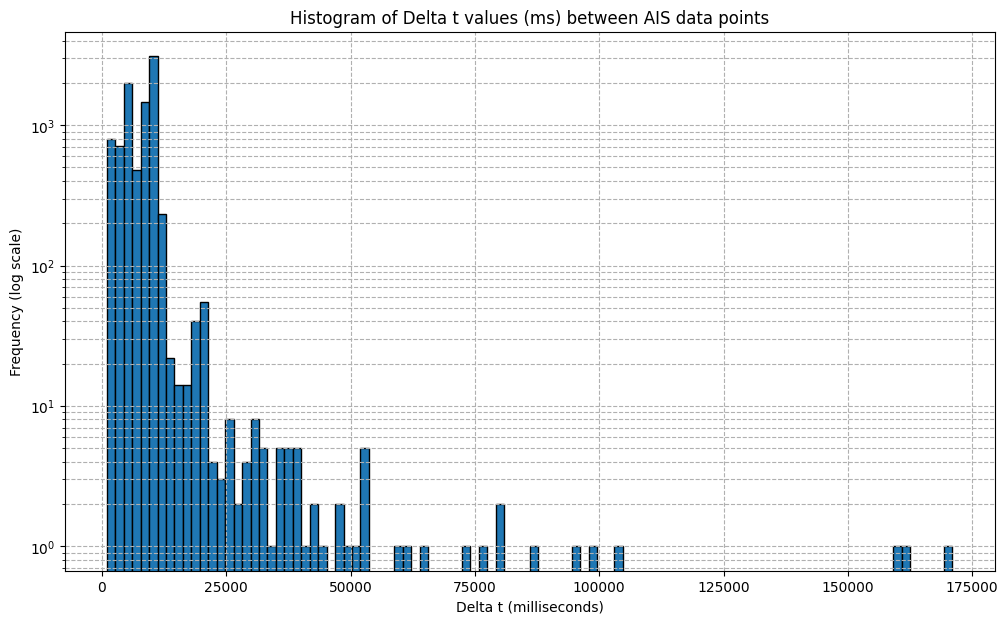

In [61]:
plt.figure(figsize=(12, 7))

positive_delta_t = [dt for dt in all_delta_t_values if dt > 0] 

plt.hist(positive_delta_t, bins=100, edgecolor='black')
plt.yscale('log', nonpositive='clip')
plt.title('Histogram of Delta t values (ms) between AIS data points')
print(f"Delta_t stats (ms): Min: {np.min(positive_delta_t):.2f}, Max: {np.max(positive_delta_t):.2f}, Mean: {np.mean(positive_delta_t):.2f}, Median: {np.median(positive_delta_t):.2f}")

plt.xlabel('Delta t (milliseconds)')
plt.ylabel('Frequency (log scale)')
plt.grid(True, which="both", linestyle='--')
plt.show()

In [ ]:
main_client.close() 